In [1]:
from post_processing import Analysis
import h5py
import numpy as np
import util
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
analysis = Analysis("diags202403071151")

100%|██████████| 1483514/1483514 [00:02<00:00, 680444.31it/s]
/lustre07/scratch/huntfeng/magnetic-nozzle-warpx/post_processing.py:141: RuntimeWarning: invalid value encountered in divide
  return data / part_per_cell
100%|██████████| 29628337/29628337 [00:44<00:00, 668276.34it/s]


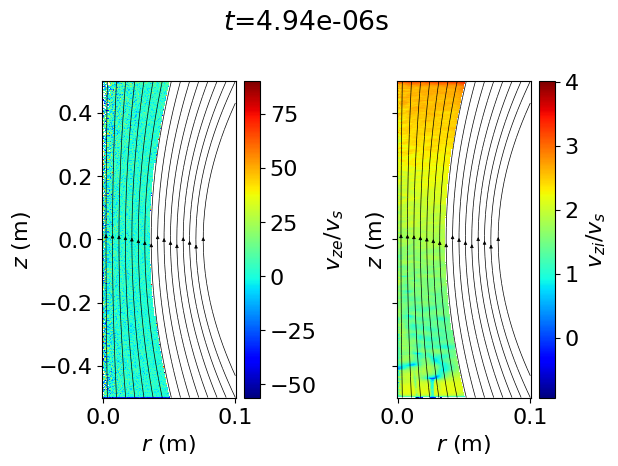

In [3]:
frame = -1
analysis.plot_velocity(frame, plot_type="slice")
# for plot_type in ["slice", "line"]:
    # analysis.plot_momentum(frame, plot_type=plot_type)
    # analysis.plot_density(frame, plot_type=plot_type)
    # analysis.plot_potential(frame, plot_type=plot_type)
    # analysis.plot_current_density(frame, direction="z", plot_type=plot_type)
# analysis.plot_part_per_cell(frame)
# analysis.plot_time(total_step=100000)